In [1]:
%load_ext autoreload
%autoreload 2
# %config Completer.use_jedi = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import json

In [3]:
# import surp.analysis.gas_phase_data as gap
import surp.analysis.apogee_analysis as aah
from surp.analysis.vice_model import vice_model
from surp import yields
from surp import analysis
from surp.analysis import gce_math as gcem

import arya
import emcee

modified solar abundances via mag++22


In [4]:
all_abundances = pd.read_csv("../notebooks/data_analysis/all_data.csv")

subgiants = aah.subgiants
filt = ~np.isnan(subgiants["C_MG"])
filt &= ~np.isnan(subgiants["MG_H"])
filt &= subgiants["high_alpha"]
subgiants = subgiants[filt]

# fiducial = vice_model("../out/C11_f0.2.json")

In [5]:
all_abundances = all_abundances.dropna()

In [6]:
X_tar = all_abundances["[o/h]"]
Y_tar = all_abundances["[c/o]"]
Y_tar_err = all_abundances["[c/o]_err"]

In [7]:
y_o = vice.yields.ccsne.settings["o"]

In [8]:
def uniform(p, lower, upper):
    if lower < p < upper:
        return 0
    else:
         return -np.inf
        
def normal(p, μ, σ):
    return np.log(1/(np.sqrt(2*np.pi)*σ)) - 1/2 *(p-μ)**2/σ**2

In [5]:
def qc_flat(q):
    return 1

def qc_lin(q):
    return q + (1-q) * np.log(1-q)

def qc_log(q):
    return q*np.log(q) + (1-q) * np.log(1-q)


def qc_sq(q):
    return 1 - (1-q)**2 - 2*(1-q)*np.log(1-q)

In [6]:
def log_prior(θ):
    τ, τs, y_c_0, ζ, a, log_f = θ
    
    if 0 < y_c_0 < 1 and (0 < log_f < 1) and (0.1 < τ < 10)\
            and (-0.1 < ζ < 0.2):
        return 0
    return -np.inf

In [205]:
def predict(θ, x):
    τ, τs, y_c_0, ζ, a, log_f = θ

    Zo = gcem.bracket_to_abundance(x, "o", "h")
    Zo_eq = y_o * τ/τs 
    q = Zo/Zo_eq
    
    yc_lin = ζ * Zo_eq
    yc_sq = a * Zo_eq**2
    
    yc_flat = y_c_0 - yc_lin - yc_sq

    
    y_c = (yc_flat*qc_flat(q) 
           + yc_lin * qc_lin(q) 
           + yc_sq * qc_sq(q))
    
    C_O = gcem.abundance_to_bracket(y_c/y_o, "c", "o")
    return C_O

In [206]:
def log_likelihood(θ, x, y, δy):
    τ, τs, y_c_0, ζ, a, log_f = θ

    pred = predict(θ, x)
    
    sigma2 = δy**2 + pred**2 * np.exp(2*log_f)

    return -0.5 * np.sum( (y-pred)**2 / sigma2 + np.log(sigma2) )

In [207]:
def log_probability(θ, x, y, δy):
    lp = log_prior(θ)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(θ, x, y, δy)

In [208]:
from scipy.optimize import minimize

In [209]:
nll = lambda *args: -log_likelihood(*args)
sol = minimize(nll, [1, 0.4, 0.003, 0.12, 0.0013, 0.02], args=(X_tar, Y_tar, Y_tar_err))
sol.x

/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([0.99999984, 0.40000041, 0.00308778, 0.11999898, 0.00130001,
       0.01999996])

/tmp/slurmtmp.24569588/ipykernel_86927/3373336710.py:5: RuntimeWarning: invalid value encountered in log
  return q + (1-q) * np.log(1-q)
/tmp/slurmtmp.24569588/ipykernel_86927/3373336710.py:12: RuntimeWarning: invalid value encountered in log
  return 1 - (1-q)**2 - 2*(1-q)*np.log(1-q)


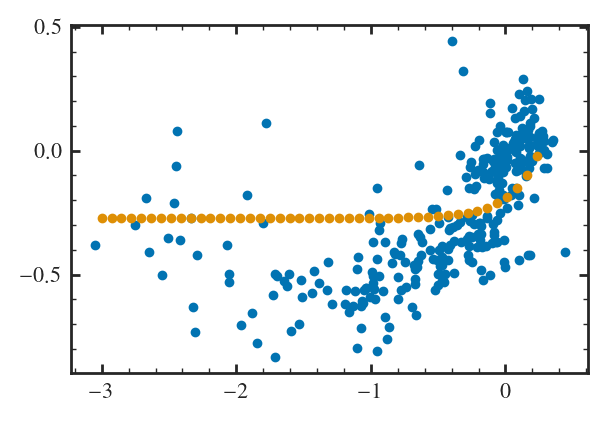

In [210]:
plt.scatter(X_tar, Y_tar)

x_pred = np.linspace(-3, 0.6)
plt.scatter(x_pred, predict(sol.x, x_pred))

In [191]:
pos = sol.x + 1e-4 * np.random.randn(12, len(sol.x))
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(X_tar, Y_tar, Y_tar_err)
)
sampler.run_mcmc(pos, 5000, progress=True);

 13%|█▎        | 630/5000 [00:15<01:49, 39.77it/s]/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 5000/5000 [01:47<00:00, 46.46it/s]


In [193]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

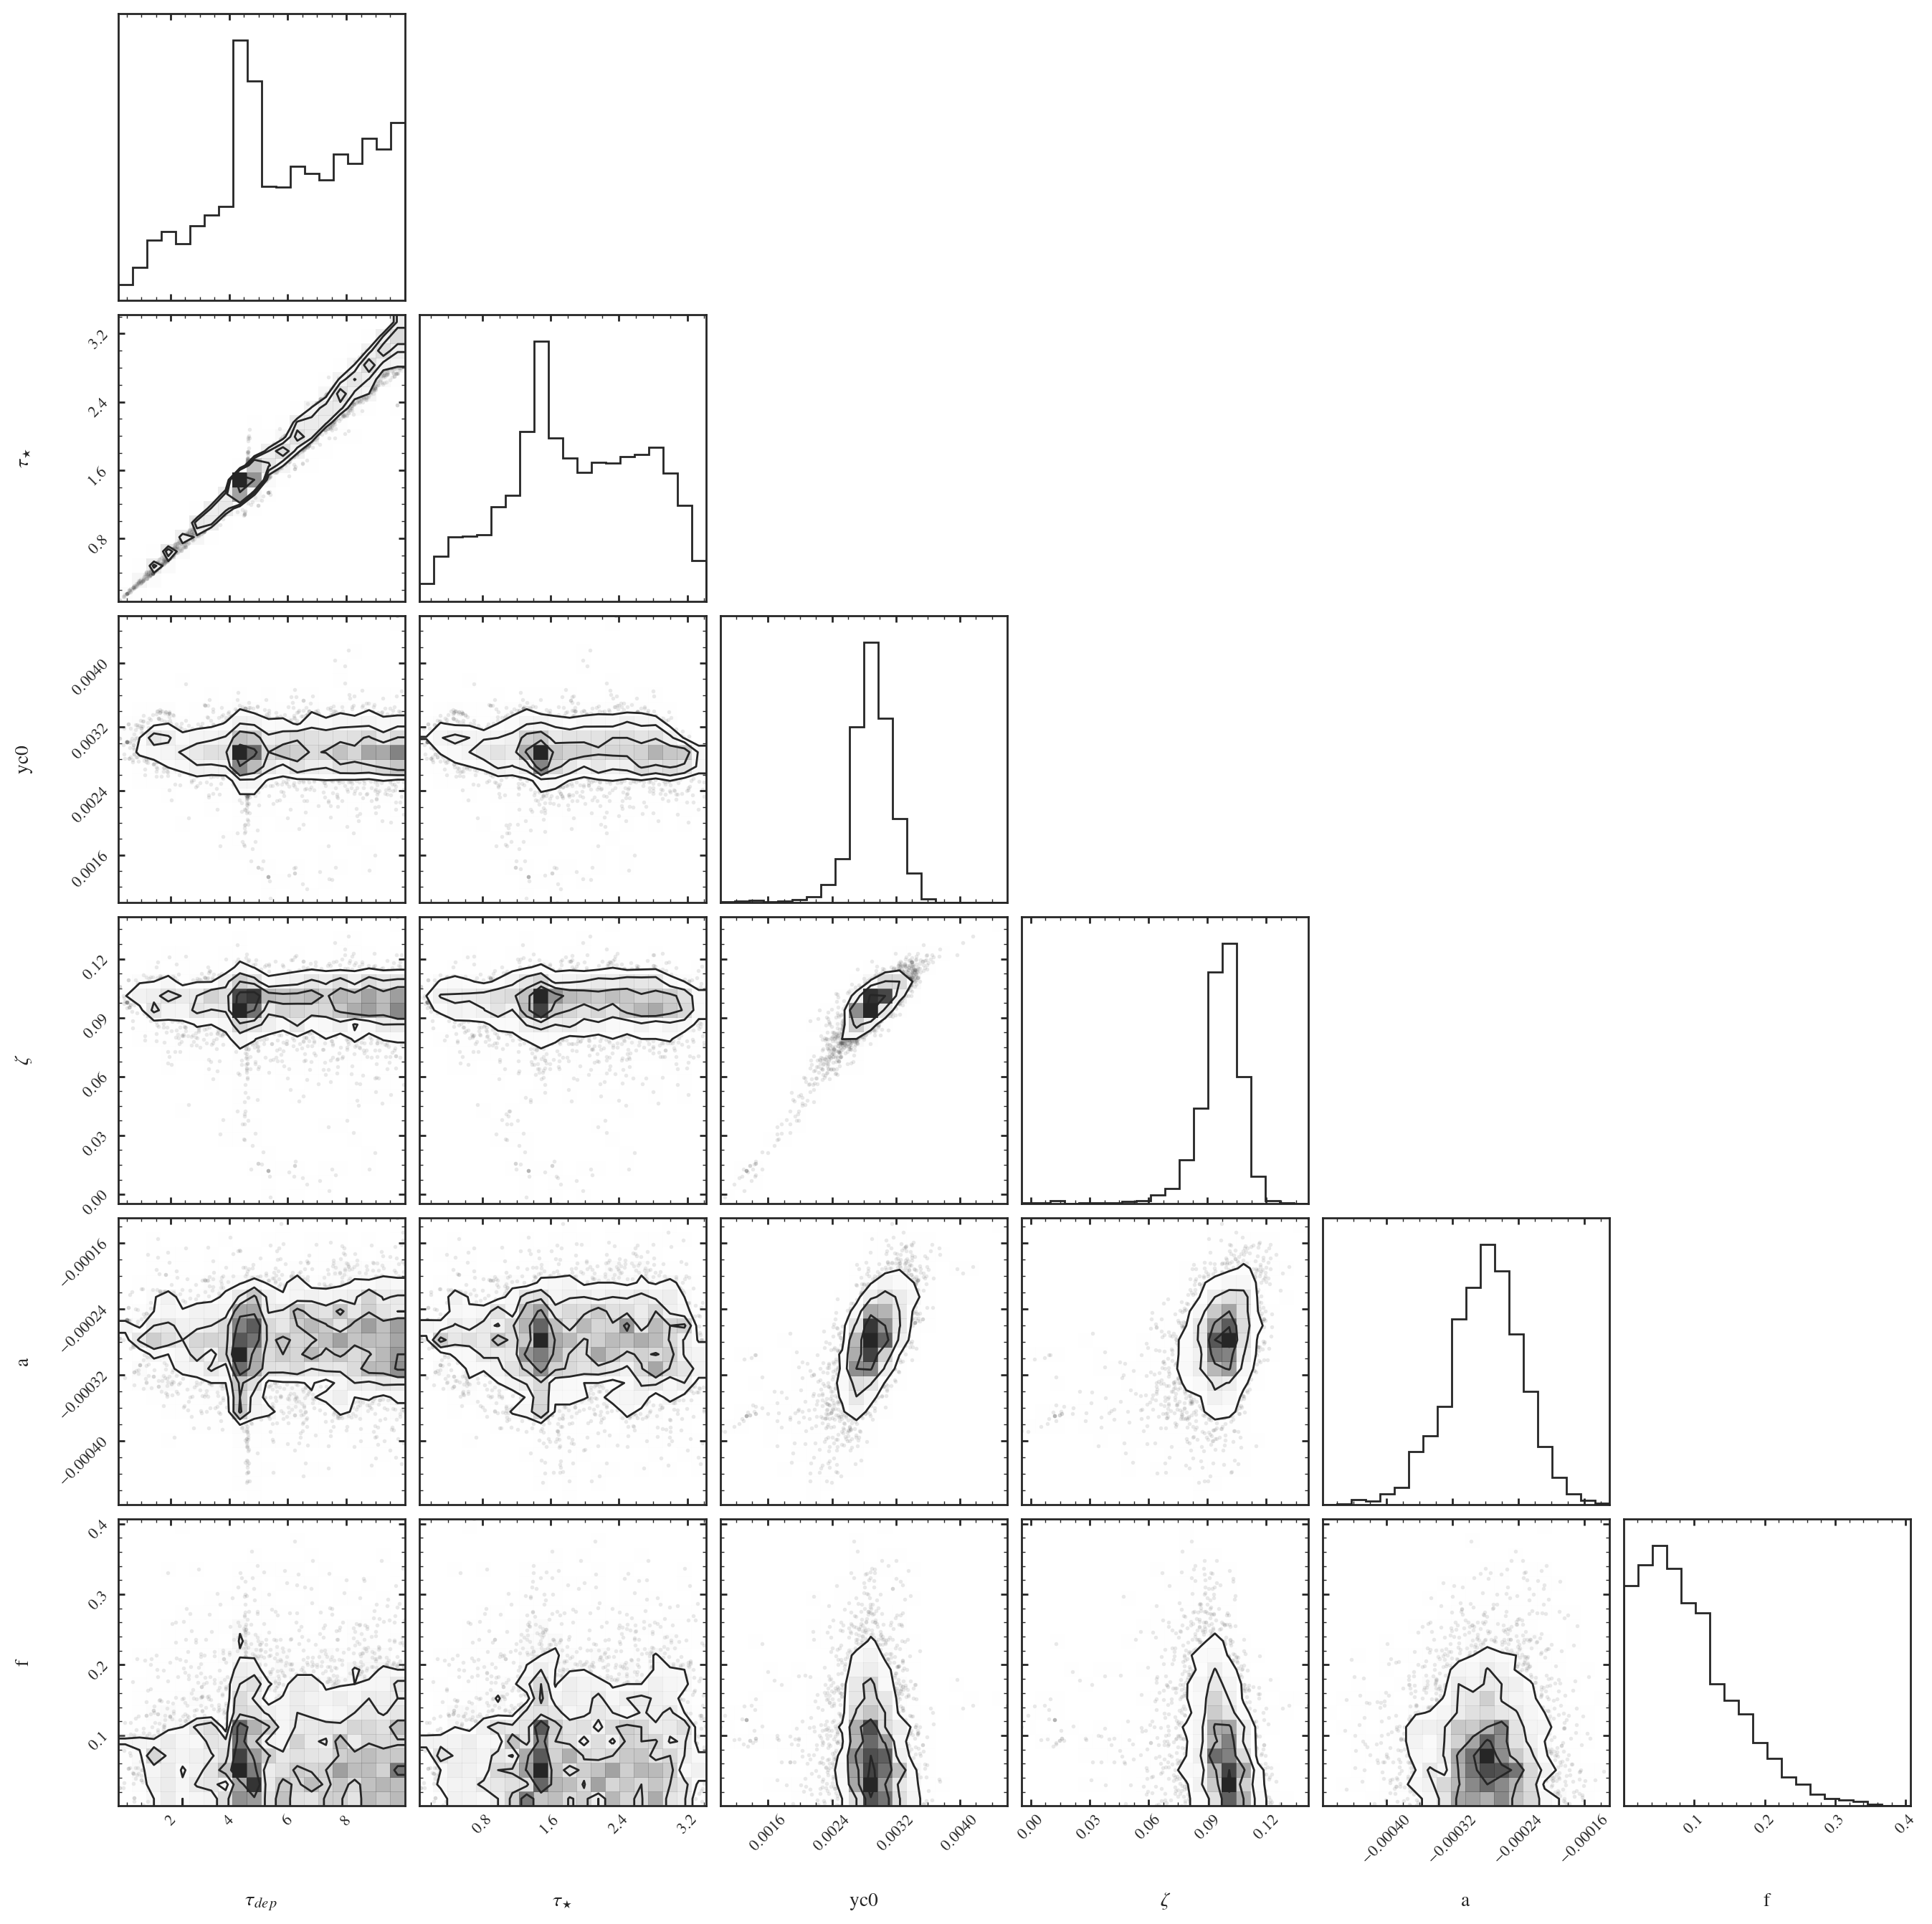

In [196]:
fig = corner.corner(flat_samples, labels=[
    r"$\tau_{dep}$", r"$\tau_\star$", r"yc0", r"$\zeta$", r"a", r"f",])


Parameters from james et al. dwarf paper:

$\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr

$\eta = 8.8 \pm 0.9$

$\tau_{\star} = 16.1 \pm 1.3\,$Gyr

$\tau_{\rm end} = 5.4\pm0.3\,$Gyr

$y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$

$y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$


As we assume different O yields, we adjust $\eta$ accordingly. Our total O yields are 0.712e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{y_O}{y_{\rm O, J+22}} = \frac{0.712}{1}
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 6.2 \pm 0.7
$$

In [9]:
def log_prior(θ):
    τ, τs = θ

    lp = uniform(τ, 0.5, 3)
    lp += normal(τs, 10, 3)
    return lp

In [10]:
pos = np.array([2, 10]) + 1e-4 * np.random.randn(12, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prior,
)
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [00:00<00:00, 2319.28it/s]


In [11]:
τ, τs = sampler.chain.transpose()

In [12]:
τ = τ.flatten()
τs = τs.flatten()

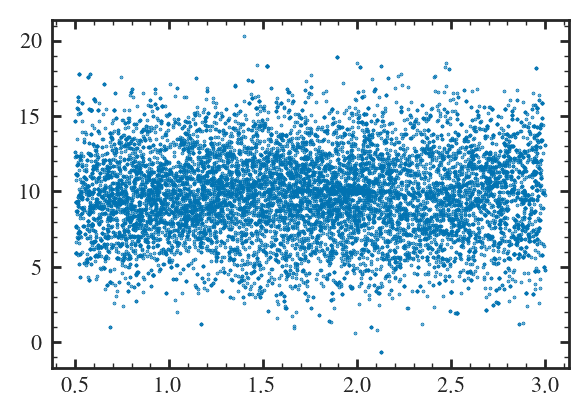

In [13]:
plt.scatter(τ, τs, s=0.1)

In [14]:
τ_ia = 1.5
t_D = 0.15
y_fe_ia = 6.69e-4
y_o = 7.12e-3
y_fe_cc = 4.72e-4


def Z_fe_cc(t, τ, τs):
    return y_fe_cc / y_o * Z_o(t, τ, τs)


def Z_ia(t, τ, τs):
    Δt = t - t_D
    
    z = y_fe_ia * τ/τs * (
    1 - np.exp(-Δt/τ)
    - 1/(1 - τ/τ_ia) * (
        np.exp(-Δt/τ_ia) - np.exp(-Δt/τ)
    ))
    
    return np.where(Δt > 0, z, 0)


def Z_fe(t, τ, τs):
    return Z_fe_cc(t, τ, τs) + Z_ia(t, τ, τs)


def Z_o(t, τ, τs):
    return y_o * τ/τs * (1 - np.exp(-t/τ))

In [15]:
def O_H(t, τ, τs):
    return gcem.abundance_to_bracket(Z_o(t, τ, τs), "o")

def FE_O(t, τ, τs):
    feo = Z_fe(t, τ, τs) / Z_o(t, τ, τs)
    return gcem.abundance_to_bracket(feo, "fe",  "o")

/users/PAS2232/aeyobd/surp/surp/analysis/gce_math.py:63: RuntimeWarning: divide by zero encountered in log10
  return np.log10(data/vice.solar_z(ele))
/tmp/slurmtmp.24595560/ipykernel_75716/651335000.py:5: RuntimeWarning: invalid value encountered in divide
  feo = Z_fe(t, τ, τs) / Z_o(t, τ, τs)


(0.0, 0.6)

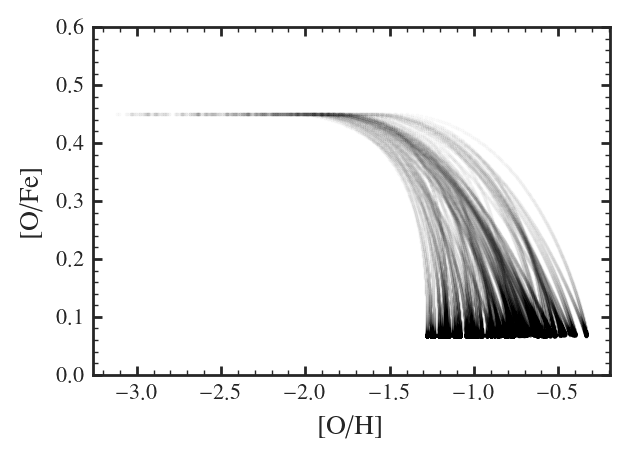

In [16]:
t = np.linspace(0, 13.2, 1000)

for i in np.random.choice(np.arange(len(τ)), 100):
    oh = O_H(t, τ[i], τs[i])
    feo = FE_O(t, τ[i], τs[i])

    plt.scatter(oh, -feo, c="k", alpha=0.03, s=0.1)
plt.xlabel("[O/H]")
plt.ylabel("[O/Fe]")
plt.ylim(0, 0.6)

In [17]:
t = np.linspace(0, 13, 300)

In [18]:
z_fe = Z_fe(t.reshape(-1, 1), τ.reshape(1, -1), τs.reshape(1, -1))
z_o =  Z_o(t.reshape(-1, 1), τ.reshape(1, -1), τs.reshape(1, -1))
y = z_o/ (y_o * τ/τs).reshape(1, -1)

X = (z_fe/z_o - y_fe_cc/y_o) / (y_fe_ia/y_o)

/tmp/slurmtmp.24595560/ipykernel_75716/3206821322.py:5: RuntimeWarning: invalid value encountered in divide
  X = (z_fe/z_o - y_fe_cc/y_o) / (y_fe_ia/y_o)


In [19]:
filt = np.isfinite(X) & np.isfinite(y)
X = X[filt]
y = y[filt]

In [20]:
from scipy.optimize import curve_fit

def emperical_q(x, b, c):
    return b*np.abs(x)**c

popt, covt = curve_fit(emperical_q, X, y)

In [21]:
x_pred = np.linspace(0, 1, 100)
y_pred = emperical_q(x_pred, *popt)

/tmp/slurmtmp.24595560/ipykernel_75716/371436497.py:7: RuntimeWarning: invalid value encountered in divide
  fe_o = Z_fe(t, τ[i], τs[i]) / o


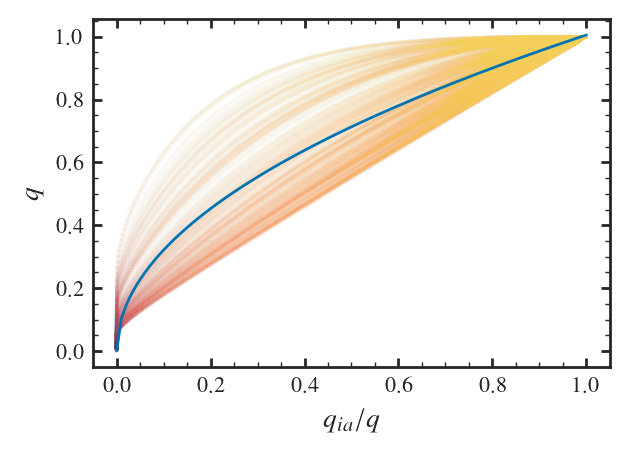

In [22]:
t = np.linspace(0, 13.2, 1000)

for i in np.random.choice(np.arange(len(τ)), 300):
    o = Z_o(t, τ[i], τs[i])
    q =  o/ (y_o * τ[i]/τs[i])
    
    fe_o = Z_fe(t, τ[i], τs[i]) / o 
    q_ia = (fe_o - y_fe_cc/y_o) / (y_fe_ia/y_o)

    plt.scatter(q_ia, q, c=O_H(t, τ[i], τs[i]), alpha=0.03, s=0.1)
    
plt.xlabel("$q_{ia}/q$")
plt.ylabel("$q$")

plt.plot(x_pred, y_pred)


In [23]:
amarsi19 = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)
amarsi19["[o/h]"] = amarsi19["[O/H]3N"]
amarsi19["[c/h]"] = amarsi19["[C/H]3N"]
amarsi19["[c/o]"] = amarsi19["[c/h]"] - amarsi19["[o/h]"] 

amarsi19["[o/h]_err"] = amarsi19["e_[O/H]3N"]
amarsi19["[c/h]_err"] = amarsi19["e_[C/H]3N"]
amarsi19["[c/o]_err"] = amarsi19["[o/h]_err"] + amarsi19["[c/h]_err"] 
amarsi19["[o/fe]"] = -amarsi19["[Fe/H]3L"] + amarsi19["[o/h]"]
amarsi19_sun = amarsi19.iloc[151]
amarsi19.drop(index=151, inplace=True)

/tmp/slurmtmp.24595560/ipykernel_75716/3032376907.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  amarsi19 = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)


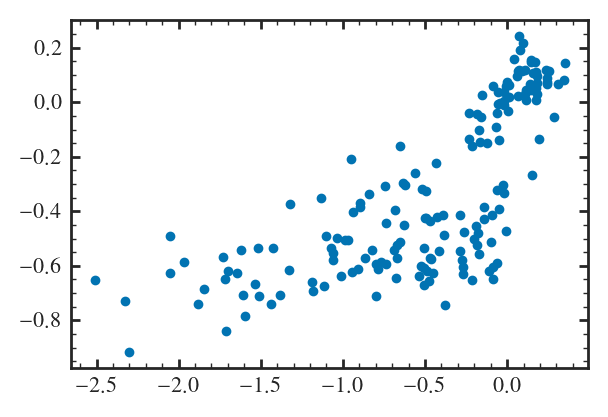

In [100]:
plt.scatter(amarsi19["[o/h]"], -amarsi19["[o/fe]"])

In [139]:
o = gcem.bracket_to_abundance(amarsi19["[o/h]"], "o")
co = gcem.bracket_to_abundance(amarsi19["[c/o]"], "c", "o")

fe_o = gcem.bracket_to_abundance(-amarsi19["[o/fe]"], "fe", "o")
q_ia = (fe_o - y_fe_cc/y_o) / (y_fe_ia/y_o)
q_ia = np.where(q_ia <= 0, 1e-3, q_ia)
q_ia /= 2.3
q = np.sqrt(q_ia)


filt = np.isfinite(o)
filt &= np.isfinite(co)

o = o[filt]
co = co[filt]
q = q[filt]
o_eq = o/q

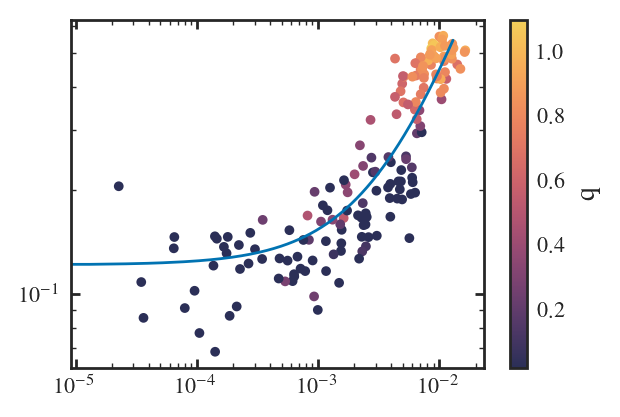

In [144]:
plt.scatter(o, co, c=q)
plt.colorbar(label="q")

def y_model(o, a, b):
    return a + o*b

popt, covt = curve_fit(y_model, o, co)

x = np.linspace(0, 0.013, 1000)
y = y_model(x, *popt)
plt.plot(x, y)
plt.xscale("log")
plt.yscale('log')

In [145]:
popt

array([ 0.12171832, 32.53822323])

In [146]:
def y_model_prime(o, a, b):
    return b + 0*o

In [147]:
def Z_c_model(o, a, b):
    return o * (a + b*o)
def Z_c_model_prime(o, a, b):
    return  a + b*o

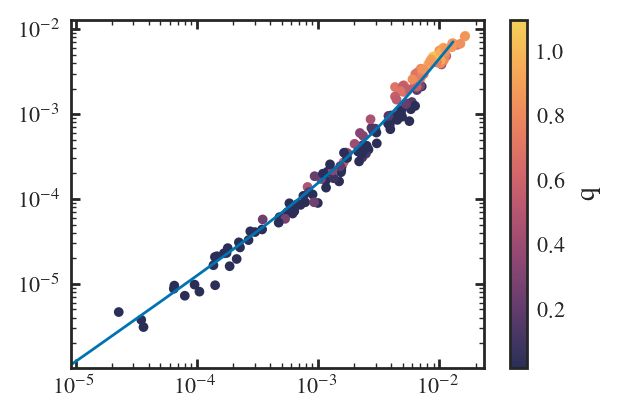

In [148]:
plt.scatter(o, co * o, c=q)
plt.colorbar(label="q")

x = np.linspace(0, 0.013, 1000)
y = Z_c_model(x, *popt)
plt.plot(x, y)
plt.xscale("log")
plt.yscale('log')

In [149]:
yp = y_model_prime(x, *popt)

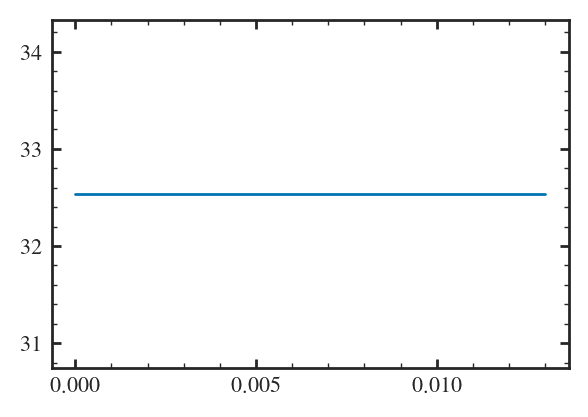

In [150]:
plt.plot(x, yp)

In [151]:
yp = y_model_prime(o, *popt)

Text(0, 0.5, 'y')

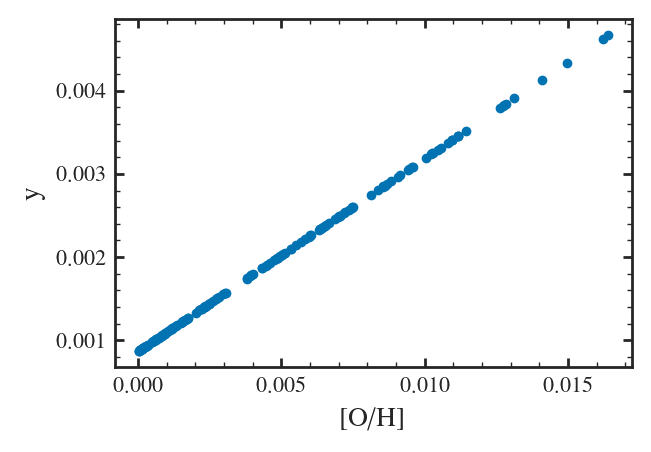

In [153]:
c = Z_c_model(o, *popt)
cp = Z_c_model_prime(o, *popt)

y_pred = y_o/o_eq * (c + (o_eq - o) * cp)
plt.scatter(o, y_pred)

def y_c_model(x, a, b):
    return a*x + b

popt, covt = curve_fit(y_c_model, o, y_pred)
plt.xlabel("[O/H]")
plt.ylabel("y")

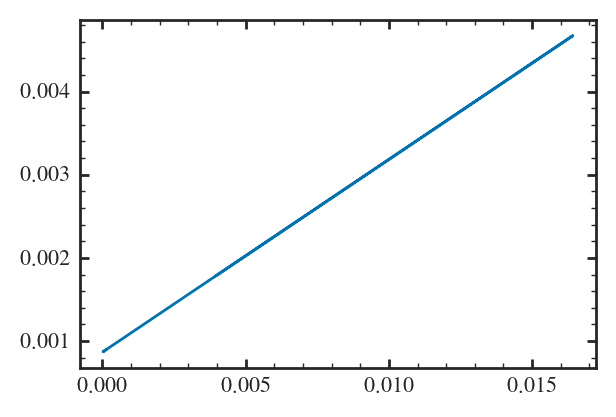

In [156]:
plt.plot(o, y_c_model(o, *popt))

todo: next step, apply this to amarsi+19 

- use fe/o to estimate $q$
- use $q$ to estimate $O_{\rm eq}$
- From $Z_C$, $dZ_C/dZ_O$, and $O_{eq}$ for each point, we can estimate the $y(O)$ relationship.

In [215]:
from surp.analysis.apogee_analysis import subgiants

In [279]:
o = gcem.bracket_to_abundance(subgiants["MG_H"], "o")
co = gcem.bracket_to_abundance(subgiants["C_MG"], "c", "o")

fe_o = gcem.bracket_to_abundance(-subgiants["MG_FE"], "fe", "o")
q_ia = (fe_o - y_fe_cc/y_o) / (y_fe_ia/y_o)
q_ia = np.where(q_ia <= 0, 1e-3, q_ia)
q_ia /= 1.2
q = np.sqrt(q_ia)


filt = np.isfinite(o)
filt &= np.isfinite(co)
filt &= ~subgiants.high_alpha

o = o[filt]
co = co[filt]
q = q[filt]
o_eq = o/q

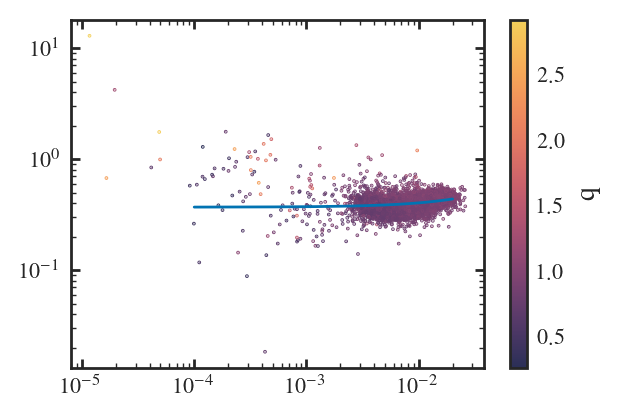

In [281]:
plt.scatter(o, co, c=q, s=0.1)
plt.colorbar(label="q")

def y_model(o, a, b):
    return a + o*b

popt, covt = curve_fit(y_model, o, co)

x = np.linspace(1e-4, 0.02, 1000)
y = y_model(x, *popt)
plt.plot(x, y)
plt.xscale("log")
plt.yscale('log')

In [282]:
def Z_c_model(o, a, b):
    return o * (a + b*o)
def Z_c_model_prime(o, a, b):
    return  a + b*o

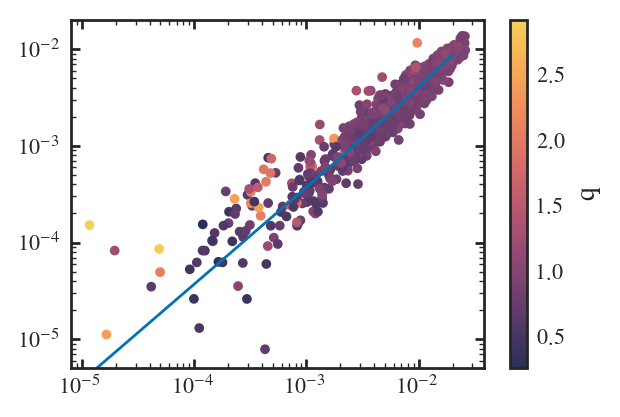

In [283]:
plt.scatter(o, co * o, c=q)
plt.colorbar(label="q")

x = np.linspace(0, 0.02, 1000)
y = Z_c_model(x, *popt)
plt.plot(x, y)
plt.xscale("log")
plt.yscale('log')

In [284]:
popt

array([0.37032056, 3.4156421 ])

In [285]:
y_o

0.00712

Text(0, 0.5, 'y')

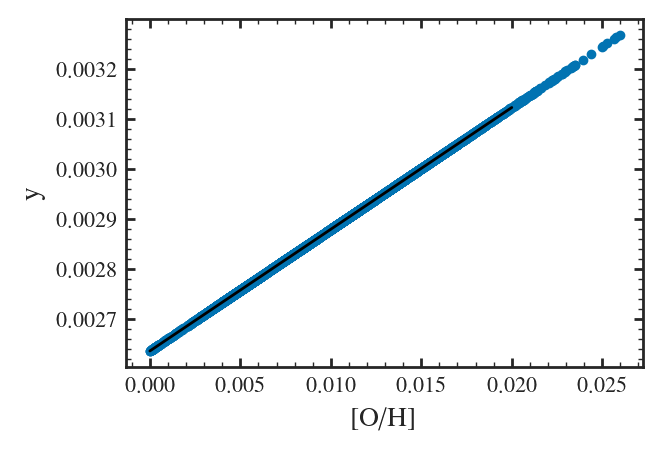

In [288]:
c = Z_c_model(o, *popt)
cp = Z_c_model_prime(o, *popt)

y_pred = y_o/o_eq * (c + (o_eq - o) * cp)
plt.scatter(o, y_pred)

def y_c_model(x, a, b):
    return a*x + b

popt2, covt2 = curve_fit(y_c_model, o, y_pred)

x = np.linspace(0, 0.02, 1000)
plt.plot(x, y_c_model(x, *popt2), color="k")
plt.xlabel("[O/H]")
plt.ylabel("y")

In [289]:
popt2

array([0.02431937, 0.00263668])

In [199]:
vice.yields.ccsne.settings["c"] = lambda Z: 8.666e-4 + 0.2316*Z
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c")
vice.yields.ccsne.settings["o"] = y_o

In [200]:
def sfh(tau=300):
    return lambda t: 1

def sz_model(eta=0, tau_star=3.1, t_end=13, tau_sfh=300, dt=0.005):
    sz = vice.singlezone(elements=["o", "mg", "c", "fe"], dt=dt, eta=eta, func=sfh(tau=tau_sfh), mode="ifr", tau_star=tau_star, Mg0=0)
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    return out

In [208]:
model = sz_model()

/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/core/singlezone/singlezone.py:269: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1850: VisibleRuntimeWarning: Functions of stellar mass and metallicity #for asymptotic giant branch star yields may significantly increase the #required integration time, especially for fine #timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/.local/lib/python3.9/site-packages/vice-1.4.0.dev2-py3.9-linux-x86_64

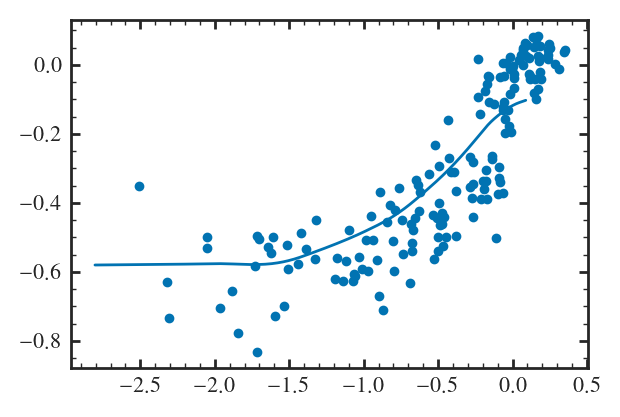

In [211]:
plt.plot(model.history["[o/h]"], model.history["[c/o]"])
plt.scatter(amarsi19["[o/h]"], amarsi19["[c/o]"])

In [159]:
sz = vice.singlezone("c")

TypeError: __init__() takes 1 positional argument but 2 were given

In [204]:
import surp

modified solar abundances via mag++22
Yield settings
X       CC                            agb                           SN Ia
 8.67e-04 + 1.24e-01 Z, else1.36 × cristallo11            0
n       5.00e-04                      0.00e+00 M + 5.02e-04 M Z/Z0  6.43e-09
o       7.13e-03                      0                             0
mg      6.52e-04                      0                             0
fe      4.73e-04                      0                             7.70e-04




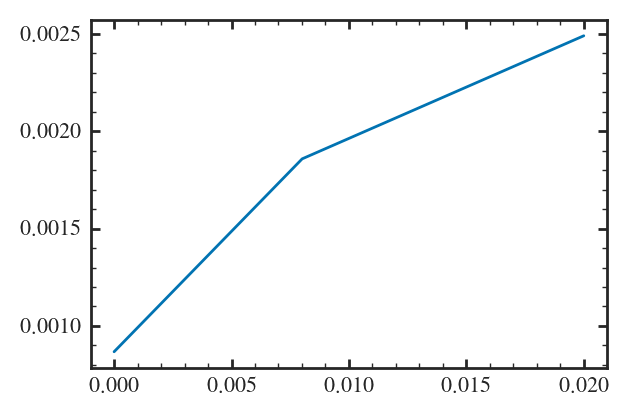

In [212]:
surp.yields.set_yields()
y = vice.yields.ccsne.settings["c"]
z = np.linspace(0, 0.02, 1000)
plt.plot(z, y(z))